In [46]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import os
import time
import pydrake
from pydrake.all import (
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
from geometric_only_grammar import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 1 child, 0. = infinite children)
- the region in which children will be produced (uniformly at random), in the frame of the node, in the form of an axis-aligned bounding box

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

Text(0.5, 1.0, 'Observed nodes')

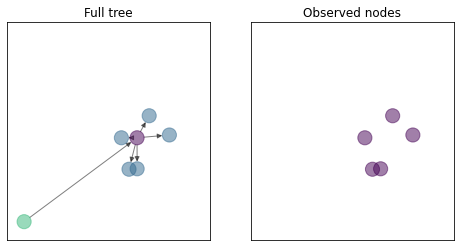

In [75]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    #"cluster_cluster": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[-np.ones(2)*0.2, np.ones(2)*0.22]),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=5, bounds=[-np.ones(2)*0.2, np.ones(2)*0.2]),
    "root": NodeDefinition(child_type="cluster", p=0.5, max_children=5, bounds=[np.ones(2)*0.2, np.ones(2)*0.8])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(7)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

Text(0.5, 1.0, 'Super tree for cluster grammar')

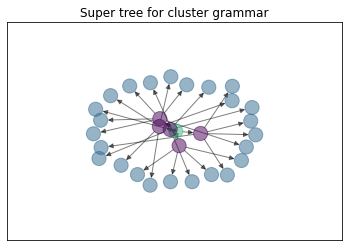

In [76]:
def make_super_tree(grammar):
    # Same logic as sampling a tree, but instead takes *all*
    # choices (but doesn't bother with sampling x).
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = parent_def.max_children

        for k in range(n_children):
            child = Node(parent_def.child_type, np.zeros(2))
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree
super_tree = make_super_tree(cluster_grammar)
draw_tree(super_tree, draw_pos=False)
plt.xlim([-2., 2.])
plt.ylim([-2., 2.])
plt.title("Super tree for cluster grammar")

In [77]:
def infer_max_entropy_tree(grammar, observed_nodes, observed_node_types, verbose=False):
    super_tree = make_super_tree(grammar)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Every node gets a binary variable to indicate
    # whether it's active or node. This is equivalent to a
    # binary variable on the incoming edge for the node.
    active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
    for k, node in enumerate(super_tree.nodes):
        node.active = active_vars[k]

    # Every observed node type gets a position;
    # every other node type gets lower and upper bounds on position, describing
    # a uniform distribution on the node position.
    for node_k, node in enumerate(super_tree.nodes):
        if node.type in observed_node_types:
            node.x_optim = prog.NewContinuousVariables(2, "%d_x_delta" % (node_k))
            prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim)
        else:
            node.x_optim_lb = prog.NewContinuousVariables(2, "%d_x_lb" % (node_k))
            node.x_optim_ub = prog.NewContinuousVariables(2, "%d_x_ub" % (node_k))
            for k in range(2):
                prog.AddLinearConstraint(node.x_optim_lb[k] <= node.x_optim_ub[k])
            prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_lb)
            prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_ub)
            if node.type is "root":
                # Force to origin
                prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_lb)
                prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_ub)

    # For each node in the super tree, add relationships between the parent
    # and that node.
    for parent_node in super_tree:
        children = list(super_tree.successors(parent_node))
        child_actives = [c.active for c in children]
        parent_node.child_actives = child_actives

        # Children active requires parent active.
        for child_active in child_actives:
            prog.AddLinearConstraint(parent_node.active >= child_active)

        # Geometric node child ordering to reduce duplicate parse: a child can
        # only be active if the previous child is also active.
        for k in range(len(child_actives) - 1):
            # child_{k+1} implies child_k
            # i.e. child_k >= child_{k+1}
            prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])
        # Child supports should be ordered, to break symmetries.
        for child, next_child in zip(children[:-1], children[1:]):
            if child.type in observed_node_types:
                prog.AddLinearConstraint(next_child.x_optim[0] >= child.x_optim[0])
            else:
                # TODO(gizatt) Upper bounds too? Worried about being too restrictive.
                prog.AddLinearConstraint(next_child.x_optim_lb[0] >= child.x_optim_lb[0])

        # The geometric process we used (np.random.geometric) is only supported
        # on k=1, ..., so constrain that the # of active children must be
        # nonzero if this node is on.
        if len(child_actives) > 0:
            prog.AddLinearConstraint(sum(child_actives) >= parent_node.active)
        
        # Child location constraints relative to parent.
        if len(children) > 0:
            lb, ub = grammar[parent_node.type].bounds
        for child_node in children:
            if parent_node.type in observed_node_types:
                raise NotImplementedError("Observed non-terminal not handled yet. Doable though?")
            if child_node.type in observed_node_types:
                # | Child location - parent location| <= bounds.
                for k in range(2):
                    prog.AddLinearConstraint(
                        child_node.x_optim[k] >= parent_node.x_optim_ub[k] + lb[k]
                    )
                    prog.AddLinearConstraint(
                        child_node.x_optim[k] <= parent_node.x_optim_lb[k] + ub[k]
                    )
            else:
                # Child lb and ub both need to be possible to be
                # generated from the parent anywhere the parent can be drawn.
                M = 1. # Max position error in an axis
                for bound in [child_node.x_optim_lb, child_node.x_optim_ub]:
                    for k in range(2):
                        prog.AddLinearConstraint(
                            bound[k] >= parent_node.x_optim_ub[k] + lb[k]
                        )
                        prog.AddLinearConstraint(
                            bound[k] <= parent_node.x_optim_lb[k] + ub[k]
                        )

    # For each observed node, add a binary variable for each possible
    # correspondence to a node in the observed set, where an active correspondence
    # forces the corresponded node to be the same position as the observed node.
    for n in super_tree:
        # (first prep some bookkeeping)
        n.outgoings = []
    for observed_node in observed_nodes:
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.type + "_sources")

        # Store these variables
        observed_node.source_actives = source_actives
        for k, n in enumerate(possible_sources):
            n.outgoings.append(source_actives[k])

        # Each observed node needs exactly one explaining input.
        prog.AddLinearEqualityConstraint(sum(source_actives) == 1)

        for k, node in enumerate(possible_sources):
            M = 1. # Should upper bound positional error in any single dimension
            # When correspondence is active, force the node to match the observed node.
            # Otherwise, it can vary within a big M of the observed node.
            for i in range(2):
                prog.AddLinearConstraint(node.x_optim[i] <= observed_node.x[i] + 1E-6 + (1. - source_actives[k]) * M)
                prog.AddLinearConstraint(node.x_optim[i] >= observed_node.x[i] - 1E-6 - (1. - source_actives[k]) * M)

    # Go back and make sure no node in the super tree is being used
    # to explain more than one observed node, and that the "observed"
    # nodes are only active if they are explaining something.
    # TODO(gizatt) These constraints are a little frustrating: without
    # them, the parsing likes to hallucinate unnecessary hidden nodes
    # since adding them increases the tree likelihood (since the net log-prob
    # of adding a new node is positive due to concentrated densities).
    # It makes me feel like I'm doing something fundamentally wrong, like using
    # total model prob to do model comparisons between models of different size.
    for node in super_tree:
        if node.type in observed_node_types:
            if len(node.outgoings) > 0:
                prog.AddLinearConstraint(sum(node.outgoings) <= 1)
                prog.AddLinearConstraint(node.active == sum(node.outgoings))
            else:
                # Never observed this type, so this node can't be active.
                prog.AddLinearConstraint(node.active == 0)
            
    # Finally, build the maximum entropy objective.
    entropy = 0.
    for parent_node in super_tree:
        # For the discrete states, do maximum likelihood.
        children = list(super_tree.successors(parent_node))
        if len(children) > 0:
            p = grammar[parent_node.type].p
            for child in children:
                prog.AddLinearCost(-np.log(1.-p) * child.active)
        
        # For continuous states, do maximum entropy.
        # The (differential) entropy of a uniform distribution is
        # int_[lb, ub] -ln(1/(ub-lb))/(ub - lb) dx = -ln(1/(ub-lb)) = ln(ub - lb)
        # which isn't linear/quadratic. However, since it's the only entry in
        # the objective here, we can just use (ub - lb) as the objective and get
        # the same result.
        if parent_node.type not in observed_node_types:
            prog.AddLinearCost(-sum(parent_node.x_optim_ub - parent_node.x_optim_lb))

    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    if verbose:
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    TreeInferenceResults = namedtuple("TreeInferenceResults", ["optim_result", "super_tree", "observed_nodes", "observed_node_types"])
    return TreeInferenceResults(result, super_tree, observed_nodes, observed_node_types)
    

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
start_time = time.time()
inference_results = infer_max_entropy_tree(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)

Num vars:  230
Num constraints:  869
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 22:12:16 2021


Took 0.105205 secs


root [0. 0.] [0. 0.]
cluster [0.65914608 0.38454015] [0.77532787 0.48942108]
point [0.57532787 0.46299754]
point [0.62032673 0.28942108]
point [0.66839846 0.29186699]
point [0.73964427 0.58454015]
point [0.85914608 0.47844289]


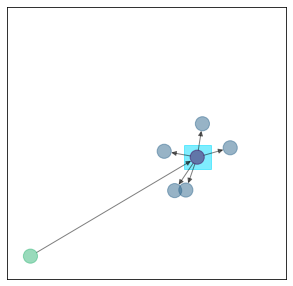

In [78]:
# Draw all ways of explaining the given scene, with support boxes for each node type.
# Sample trees from the results:
from matplotlib.patches import Rectangle
def draw_max_entropy_tree(inference_results, ax=None):
    if ax is None:
        plt.figure().set_size_inches(5, 5)
        ax = plt.gca()

    # Grab that supertree from optimization
    optim_result = inference_results.optim_result
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes
    observed_node_types = inference_results.observed_node_types

    # Sanity-check observed nodes are explained properly.
    for observed_node in observed_nodes:
        if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

    illustration_tree = nx.DiGraph()
    colors_by_type = {}
    node_colors = {}
    for node in super_tree:
        if optim_result.GetSolution(node.active):
            illustration_tree.add_node(node)
            color = plt.get_cmap("jet")(np.random.random())
            node_colors[node] = color
            # Put node xy at center of support region
            # and draw support regions
            if node.type in observed_node_types:
                # Node xy distribution is delta -> copy it over
                print(node.type, optim_result.GetSolution(node.x_optim))
                node.x = optim_result.GetSolution(node.x_optim)
            else:
                # Node xy distribution is Uniform -> sample
                lb = optim_result.GetSolution(node.x_optim_lb)
                ub = optim_result.GetSolution(node.x_optim_ub)
                print(node.type, lb, ub)
                node.x = (lb + ub) / 2.
                ax.add_patch(
                    Rectangle(lb, ub[0]-lb[0], ub[1]-lb[1],
                             color=color,
                             alpha=0.5))
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert parent.active
                illustration_tree.add_edge(parent, node)
    # Draw
    draw_tree(illustration_tree, alpha=0.5, ax=ax, node_size=200)

draw_max_entropy_tree(inference_results)

Num vars:  230
Num constraints:  869
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 22:12:20 2021


0: Inferred for 5 node scene in 0.105662 secs
root [0. 0.] [0. 0.]
cluster [0.2 0.2] [0.56178263 0.46228124]
cluster [0.61457772 0.53189568] [0.8        0.71503563]
point [0.36178263 0.26228124]
point [0.6041495  0.71836623]
point [0.65633244 0.73189568]
point [0.74580264 0.57321499]
point [0.81457772 0.51503563]
Num vars:  155
Num constraints:  566
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 22:12:20 2021


1: Inferred for 2 node scene in 0.046310 secs
root [0. 0.] [0. 0.]
cluster [0.30669778 0.2       ] [0.69089805 0.23700506]
point [0.49089805 0.03700506]
point [0.50669778 0.13829392]
Num vars:  155
Num constraints:  566
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 22:12:21 2021


2: Inferred for 2 node scene in 0.047644 secs
root [0. 0.] [0. 0.]
cluste

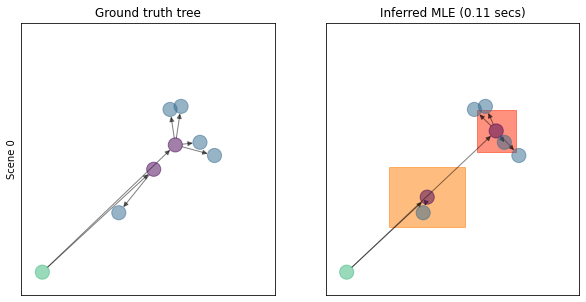

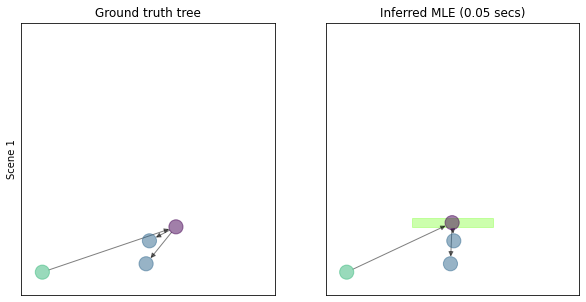

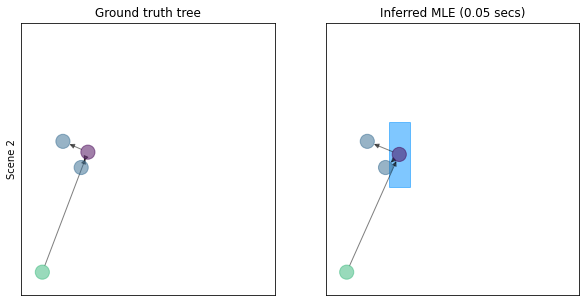

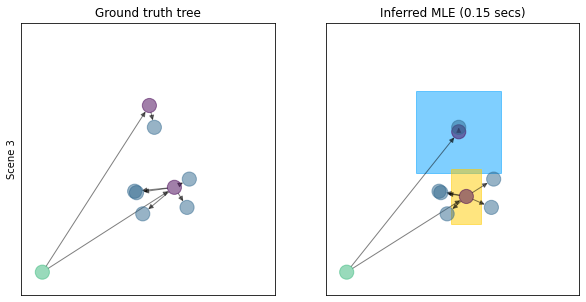

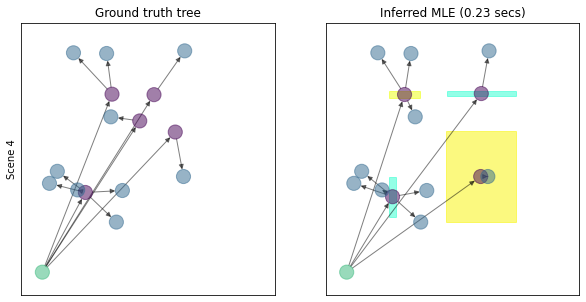

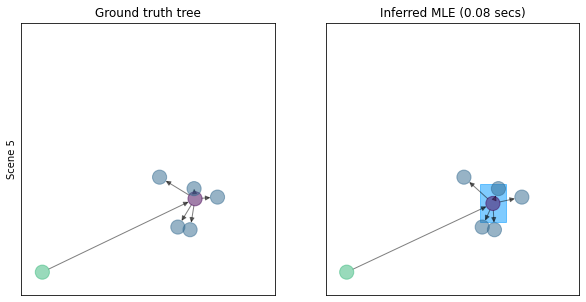

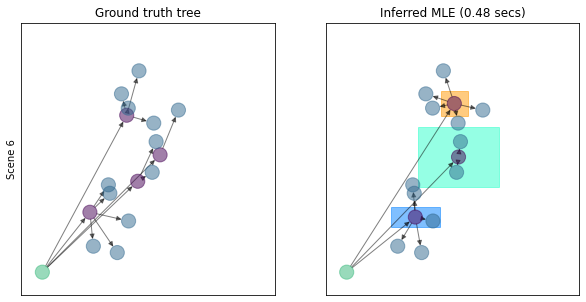

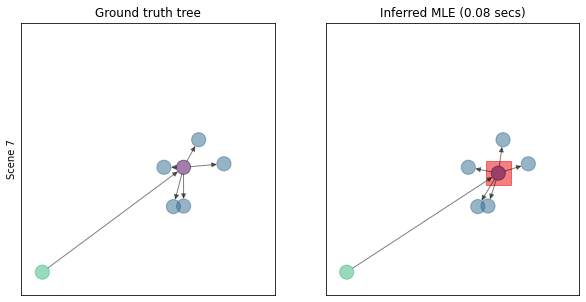

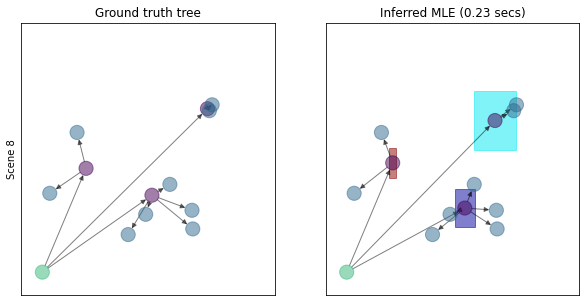

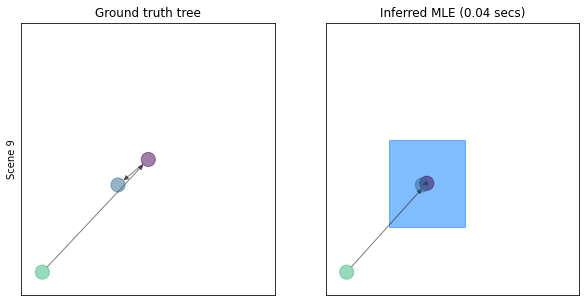

In [79]:
# Generate + infer on a bunch of trees.
N = 10
for k in range(N):
    plt.figure().set_size_inches(10, 5)
    np.random.seed(k)
    plt.subplot(1, 2, 1)
    example_tree = sample_tree(cluster_grammar)
    observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
    draw_tree(example_tree)
    plt.title("Ground truth tree")
    plt.ylabel("Scene %d" % k)
    start_time = time.time()
    inference_results = infer_max_entropy_tree(cluster_grammar, observed_nodes, cluster_grammar_observed_types, verbose=True)
    elapsed = time.time() - start_time
    print("%d: Inferred for %d node scene in %f secs" % (k, len(observed_nodes), elapsed))
    if not inference_results.optim_result.is_success():
        print("WARN: Failed optimization.")
        continue
    
    #plt.subplot(1, 3, 3)
    #draw_mle_tree_corrs(inference_results)
    
    plt.subplot(1, 2, 2)
    draw_max_entropy_tree(inference_results, ax=plt.gca())
    plt.title("Inferred MLE (%0.02f secs)" % elapsed)
